# Week 8 – K-Nearest Neighbors

This notebook applies **K-Nearest Neighbors (KNN)** to the Chronic Kidney Disease dataset for:

- **Classification**: Predicting the binary `Diagnosis` label  
- **Regression**: Predicting the continuous lab value `SerumCreatinine`  


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

DATA_PATH = "Chronic_Kidney_Dsease_data.csv"

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(1659, 54)


,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge
0,1,71,0,0,0,2,31.069414,1,5.128112,1.676220,...,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1,Confidential
1,2,34,0,0,1,3,29.692119,1,18.609552,8.377574,...,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1,Confidential
2,3,80,1,1,0,1,37.394822,1,11.882429,9.607401,...,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1,Confidential
3,4,40,0,2,0,1,31.329680,0,16.020165,0.408871,...,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1,Confidential
4,5,43,0,1,1,2,23.726311,0,7.944146,0.780319,...,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1,Confidential


## Basic Cleaning and Feature Setup

In [2]:
# Drop identifier-like / non-informative columns
df = df.drop(columns=["PatientID", "DoctorInCharge"], errors="ignore")

# Separate targets
y_clf = df["Diagnosis"]
y_reg = df["SerumCreatinine"]

X = df.drop(columns=["Diagnosis", "SerumCreatinine"], errors="ignore")

# Identify numeric vs categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_features, categorical_features

(['Age',
  'Gender',
  'Ethnicity',
  'SocioeconomicStatus',
  'EducationLevel',
  'BMI',
  'Smoking',
  'AlcoholConsumption',
  'PhysicalActivity',
  'DietQuality',
  'SleepQuality',
  'FamilyHistoryKidneyDisease',
  'FamilyHistoryHypertension',
  'FamilyHistoryDiabetes',
  'PreviousAcuteKidneyInjury',
  'UrinaryTractInfections',
  'SystolicBP',
  'DiastolicBP',
  'FastingBloodSugar',
  'HbA1c',
  'BUNLevels',
  'GFR',
  'ProteinInUrine',
  'ACR',
  'SerumElectrolytesSodium',
  'SerumElectrolytesPotassium',
  'SerumElectrolytesCalcium',
  'SerumElectrolytesPhosphorus',
  'HemoglobinLevels',
  'CholesterolTotal',
  'CholesterolLDL',
  'CholesterolHDL',
  'CholesterolTriglycerides',
  'ACEInhibitors',
  'Diuretics',
  'NSAIDsUse',
  'Statins',
  'AntidiabeticMedications',
  'Edema',
  'FatigueLevels',
  'NauseaVomiting',
  'MuscleCramps',
  'Itching',
  'QualityOfLifeScore',
  'HeavyMetalsExposure',
  'OccupationalExposureChemicals',
  'WaterQuality',
  'MedicalCheckupsFrequency',
  'Me

## Preprocessing Pipelines

In [3]:
# Numeric: median imputation + standardization
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: most frequent + one-hot
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Train-test split (same split used for both tasks for consistency)
X_train, X_test, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# For regression, we reuse X_train/X_test but keep a separate target
_, _, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

## KNN Classification – Predicting Diagnosis

In [4]:
knn_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsClassifier())
])

param_grid_clf = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]  # Manhattan vs Euclidean
}

grid_clf = GridSearchCV(
    knn_clf,
    param_grid_clf,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_clf.fit(X_train, y_train_clf)

print("Best params (classification):", grid_clf.best_params_)
print("Best CV F1:", grid_clf.best_score_)

best_clf = grid_clf.best_estimator_
y_pred_clf = best_clf.predict(X_test)
y_proba_clf = best_clf.predict_proba(X_test)[:, 1]

print("\nTest Accuracy:", accuracy_score(y_test_clf, y_pred_clf))
print("Test F1:", f1_score(y_test_clf, y_pred_clf))
print("Test ROC-AUC:", roc_auc_score(y_test_clf, y_proba_clf))
print("\nClassification report:\n", classification_report(y_test_clf, y_pred_clf))

cm = confusion_matrix(y_test_clf, y_pred_clf)
print("\nConfusion matrix:\n", cm)

Best params (classification): {'model__n_neighbors': 9, 'model__p': 2, 'model__weights': 'uniform'}
Best CV F1: 0.9579567112645531

Test Accuracy: 0.9186746987951807
Test F1: 0.957613814756672
Test ROC-AUC: 0.518154219793564

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.92      1.00      0.96       305

    accuracy                           0.92       332
   macro avg       0.46      0.50      0.48       332
weighted avg       0.84      0.92      0.88       332


Confusion matrix:
 [[  0  27]
 [  0 305]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## KNN Regression – Predicting SerumCreatinine

### Residual Plot for Regression

This quick plot helps visualize how well KNN regression approximates `SerumCreatinine` on the test set.


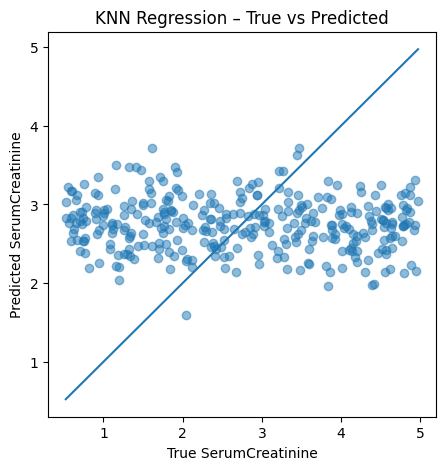

In [7]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.xlabel("True SerumCreatinine")
plt.ylabel("Predicted SerumCreatinine")
plt.title("KNN Regression – True vs Predicted")
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()])
plt.show()

In [6]:
## KNN Regression – Predicting SerumCreatinine

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Pipeline: preprocessing + KNN regressor
knn_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", KNeighborsRegressor())
])

# Hyperparameter grid for KNN regression
param_grid_reg = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15],
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

grid_reg = GridSearchCV(
    knn_reg,
    param_grid_reg,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

grid_reg.fit(X_train, y_train_reg)

print("Best params (regression):", grid_reg.best_params_)
print("Best CV MAE:", -grid_reg.best_score_)

# Use best estimator to predict on test set
best_reg = grid_reg.best_estimator_
y_pred_reg = best_reg.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = mse ** 0.5   # manual RMSE since squared=False is not supported

print("\nTest MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)


Best params (regression): {'model__n_neighbors': 15, 'model__p': 1, 'model__weights': 'uniform'}
Best CV MAE: 1.1733447013099503

Test MAE: 1.2199375413694966
Test MSE: 1.9845928853854053
Test RMSE: 1.4087557933813104
